In [42]:
# from flask import Flask, request, render_template, make_response
# from flask_restful import Api, Resource
# from flask import send_file
# from flask import send_from_directory
# from pyowm import OWM
from weatherbit.api import Api as wApi
from datetime import datetime, timedelta
import pytz
import pandas as pd
from bokeh.palettes import plasma
from bokeh.plotting import figure, show
from bokeh.embed import components
from bokeh.models import DatetimeTickFormatter
import math
import os
from bokeh.io import output_notebook
from pyowm.owm import OWM
output_notebook()
from io import BytesIO
from bokeh.io.export import get_screenshot_as_png

Loading BokehJS ...

In [33]:

owmKey = 'c2a1d5cadf8e3dbbe3af4ee8f1dba498'
owm = OWM(owmKey)
mgr = owm.weather_manager()
locations = ['Tehachapi', 'Shafter, Ca']#, 'Pomeroy, Wa', 'Ridgecrest, Ca', 'Pismo Beach, Ca', 'Houston, Tx']


def getForecastFromOWM(location):
    observation = mgr.forecast_at_place(location, 'daily').forecast
    return observation

for location in locations:
    print(str(getForecastFromOWM(location)))

UnauthorizedError: Invalid API Key provided

In [34]:
# headers = {'Content-Type': 'text/html'}
key = r'ccabeee4d6b04734b1469e9ab04e9fd9'
# if request.args:
#     key = request.args.get('key', 0)

wapi = wApi(key)
wapi.set_granularity('hourly')

# locations = locations.split(';')
locations = ['Tehachapi', 'Shafter, Ca']#, 'Pomeroy, Wa', 'Ridgecrest, Ca', 'Pismo Beach, Ca', 'Houston, Tx']
temps_h = []
temps_d = []

def getForecastFromWeatherBit(location, granularity):
    wapi.set_granularity(granularity)
    forecast = wapi.get_forecast(city=location, units='I')
    if granularity == 'hourly':
        att = 'temp'
    else:
        att = 'max_temp'
    t = forecast.get_series([att])
    dict_t = {}
    for num, temp in enumerate(t):
        if granularity == 'hourly' or num > 3:
            idx = datetime.fromtimestamp(datetime.timestamp(pytz.utc.localize(temp['datetime']))).replace(hour=0, minute=0, second=0, microsecond=0)
        else:
            if num <= 3:
                idx = datetime.fromtimestamp(
                    datetime.timestamp(
                        pytz.utc.localize(
                            temp['datetime']))).replace(hour=0, minute=0, second=0, microsecond=0)
                            #.replace(second=0, microsecond=0, minute=0, hour=temps_h[-1].iloc[-1].name.hour)+timedelta(hours = 2) ##hourly forecasts have been removed from weatherbit free tier
        dict_t.update({idx:
            {
                'temp': temp[att]
            }
        })
    df = pd.DataFrame.from_dict(dict_t, orient='index')
    return df

for location in locations:
    # temps_h.append(getForecastFromWeatherBit(location,'hourly'))##hourly forecasts have been removed from weatherbit free tier
#     print(temps_h[-1].iloc[-1].name)
    temps_d.append(getForecastFromWeatherBit(location,'daily')[0:16])

# tempH = pd.concat(temps_h,axis=1) ##hourly forecasts have been removed from weatherbit free tier
# tempH.columns = locations ##hourly forecasts have been removed from weatherbit free tier

tempD = pd.concat(temps_d,axis=1)
tempD.columns = locations

colors = plasma(len(locations*2))

p = figure(width=950, height=600, x_axis_type="datetime")

for num, location in enumerate(locations, start=0):
    # p.line(tempH.index.values, tempH[0:][location], legend=location, color=colors[num*2+1], line_width=5)##hourly forecasts have been removed from weatherbit free tier
    # p.circle(tempH.index.values, tempH[0:][location],  color=colors[num*2],size=8)##hourly forecasts have been removed from weatherbit free tier
    p.line(tempD.index.values, tempD[0:][location], legend_label=location, color=colors[num*2+1], line_dash=[10,2], line_width=3)
    p.circle(tempD.index.values, tempD[0:][location],  color=colors[num*2],size=8)

# xAxisStr = hours=["%I:00 %p"] + days=["%A %m-%d"] + months=["%A %m-%d"] + years=["%A %m-%d"]

p.xaxis.formatter=DatetimeTickFormatter(
        hours="%I:00 %p",
        days="%A %m-%d",
        months="%A %m-%d",
        years="%A %m-%d"
)

# p.xaxis.formatter = '%A %m-%d'

p.xaxis[0].ticker.desired_num_ticks = len(tempD) ## len(tempH) ##hourly forecasts have been removed from weatherbit free tier

p.xaxis.major_label_orientation = math.pi/4

p.xaxis.major_label_text_color = '#FFFFFF'
p.yaxis.major_label_text_color = '#FFFFFF'

p.xaxis.axis_line_color = '#FFFFFF'
p.yaxis.axis_line_color = '#FFFFFF'

p.xaxis.major_tick_line_color = '#FFFFFF'
p.yaxis.major_tick_line_color = '#FFFFFF'
p.yaxis.minor_tick_line_color = '#FFFFFF'   

p.xgrid.grid_line_color = '#333333'
p.ygrid.grid_line_color = '#333333'

p.toolbar.logo = None
p.border_fill_color = '#191919'
p.background_fill_color = '#191919'
# p.border_fill_color = '#949494'
# p.background_fill_color = "#949494"
p.legend.background_fill_alpha = 0.7
# output_notebook(hide_banner=True)
show(p)
script, div = components(p)
# return make_response(render_template('index.html', script=script, div=div))

ValueError: Could not save to JPEG for display

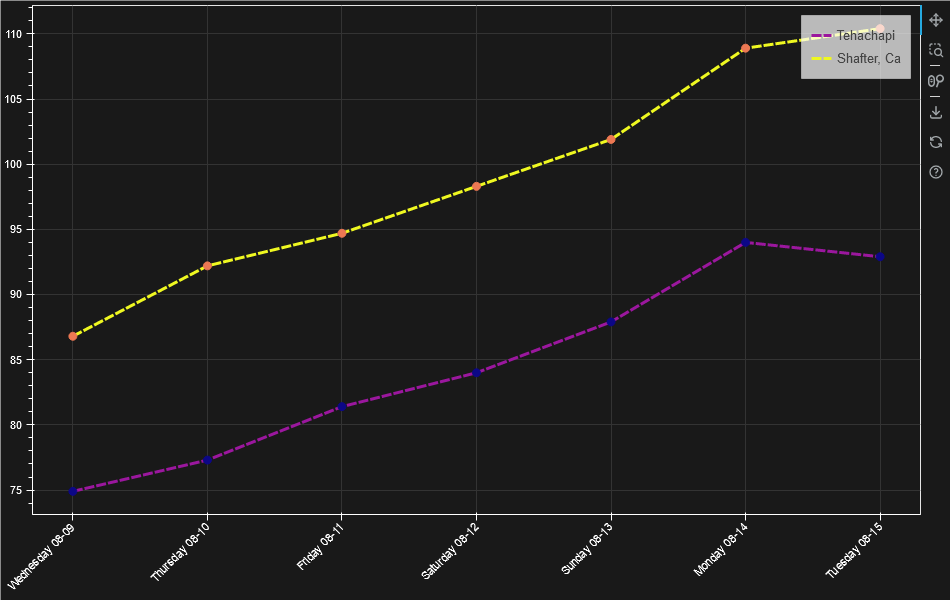

In [45]:
img = get_screenshot_as_png(p)
display(img)